In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [9]:
def cargar_datos(ruta_archivo):
    # Carga los datos del archivo CSV
    datos = pd.read_csv(ruta_archivo, delimiter=',')
    return datos
##Se realiza la carga con Pandas ya que numpy no muestra los valores categoricos
if __name__ == "__main__":
    ruta_archivo = '../ejercicios_core/data/WineQT.csv'
    df = cargar_datos(ruta_archivo)  
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


In [10]:
##Exploracion de datos
df.info()
df.describe()
##Imprimir valores unicos de quality
print(df['quality'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
[5 6 7 4 8 3]


In [11]:
# Identificar valores faltantes
def identificar_valores_faltantes(df):
    print("Valores faltantes en el dataset")
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)

    # Crear DataFrame con los resultados
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na_df = pd.DataFrame(data=aux)

    # Ordenar el DataFrame por el porcentaje de valores faltantes
    return na_df.sort_values(by='Na en %', ascending=False)

na_df = identificar_valores_faltantes(df)
print(na_df)

###No existen valores nulos

##Verificacion de elementos duplicados
###
print("Cantidad de filas duplicadas antes de la eliminacion: ",df.duplicated().sum())
###No se verifican valores duplicados

##Se elimina columnas de id que no tiene valor significativo para la prediccion
df = df.drop(columns=['Id'])  # Eliminar columna 'id'

Valores faltantes en el dataset
                      datos sin NAs en q  Na en q  Na en %
fixed acidity                       1143        0      0.0
volatile acidity                    1143        0      0.0
citric acid                         1143        0      0.0
residual sugar                      1143        0      0.0
chlorides                           1143        0      0.0
free sulfur dioxide                 1143        0      0.0
total sulfur dioxide                1143        0      0.0
density                             1143        0      0.0
pH                                  1143        0      0.0
sulphates                           1143        0      0.0
alcohol                             1143        0      0.0
quality                             1143        0      0.0
Id                                  1143        0      0.0
Cantidad de filas duplicadas antes de la eliminacion:  0


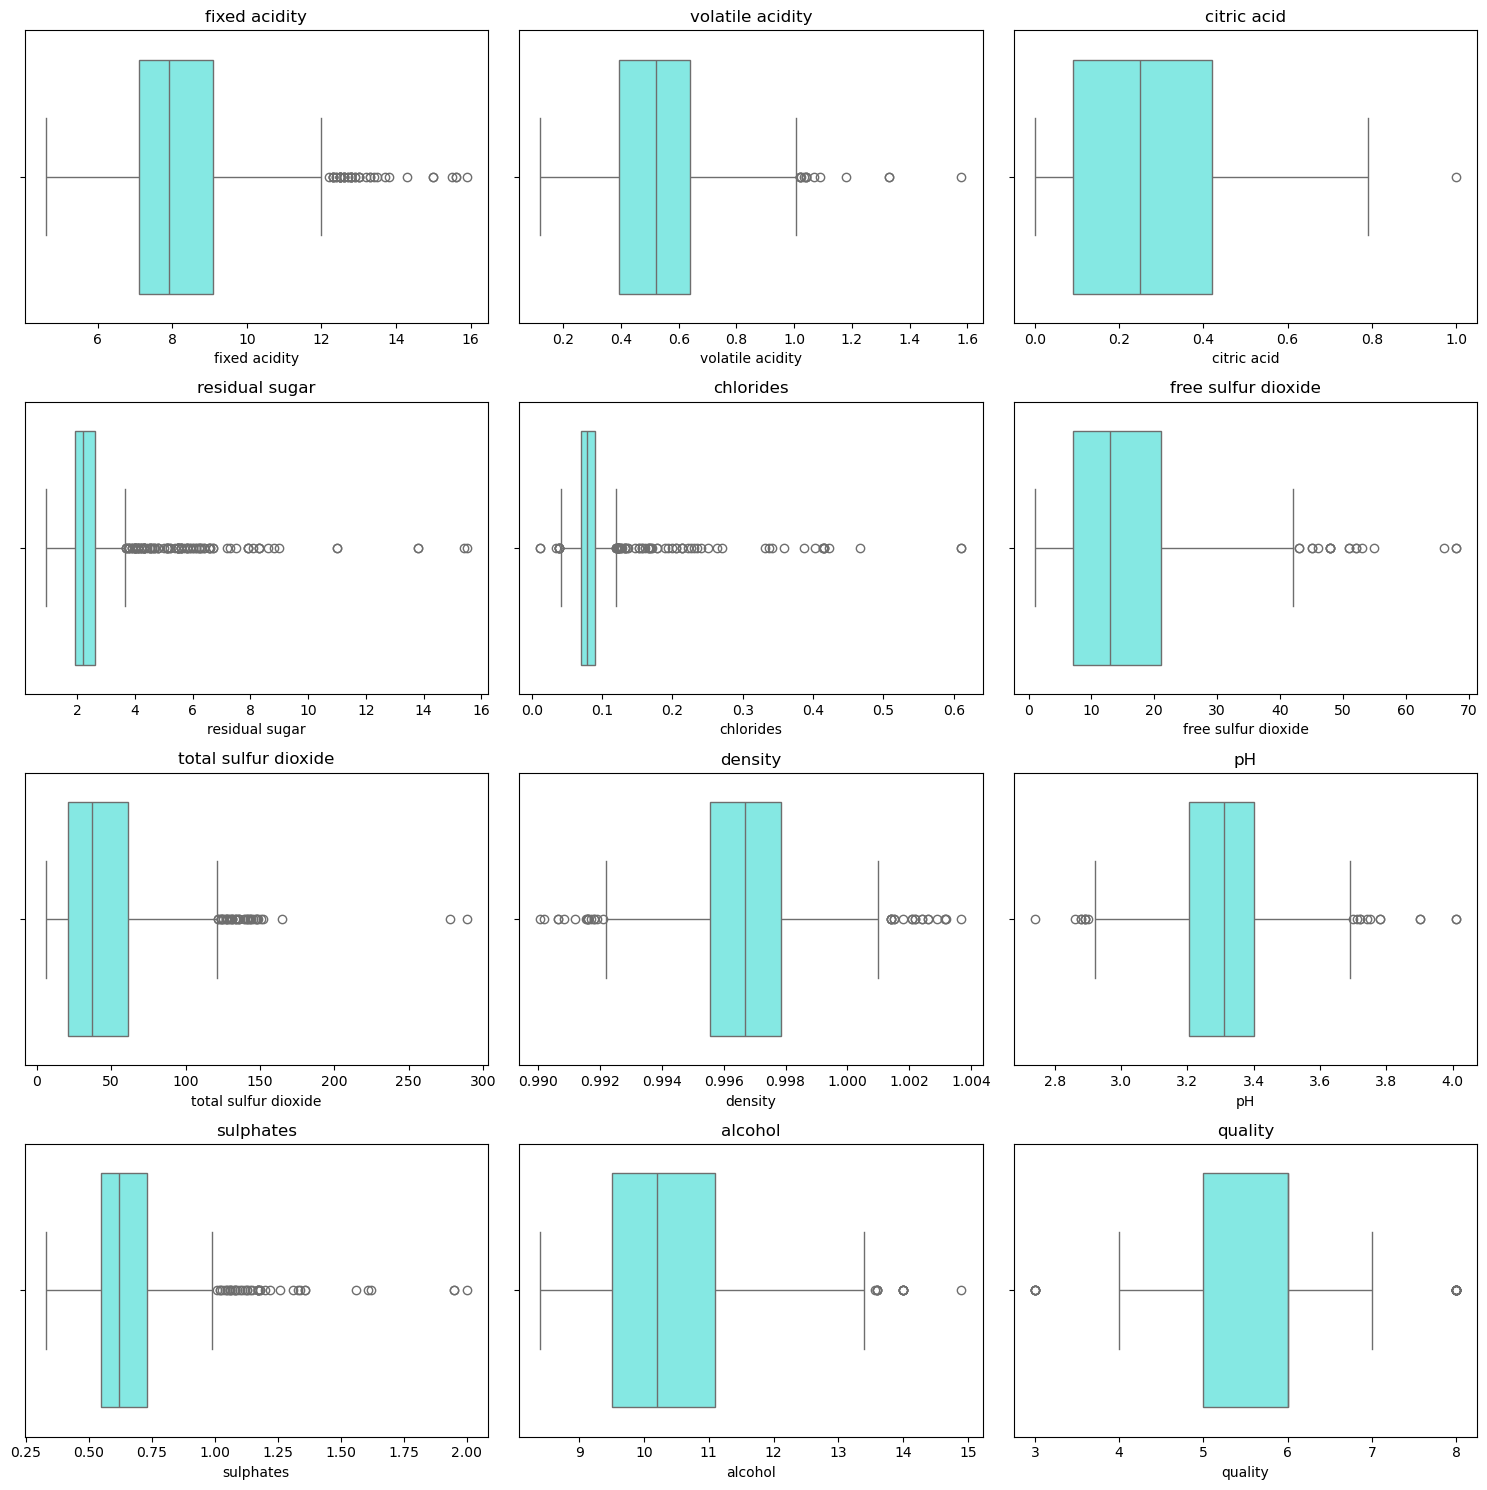

In [12]:
### Verificacion de outliers
num_features = df.select_dtypes(include=['int64', 'float64'])
def plot_grafico_outliers(num_features, df):

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

    for i, feature in enumerate(num_features):
        row, col = divmod(i, 3)
        sns.boxplot(x=df[feature], ax=axes[row, col], color="#75f8f2")
        axes[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()
plot_grafico_outliers(num_features,df)

##### Se encuentran valores outliers pero se escalan de modo a normalizarlos. No se ven datos muy dispersos a excepcion de alcohol y citric acid. Tambien se ve que las lineas de la mediana estan en su mayoria centradas, a excepcion de algunas variables por lo que los datos no se ven muy sesgadas.

In [13]:
### Separacion de datos de entrenamiento y prueba
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='quality', ylabel='chlorides'>

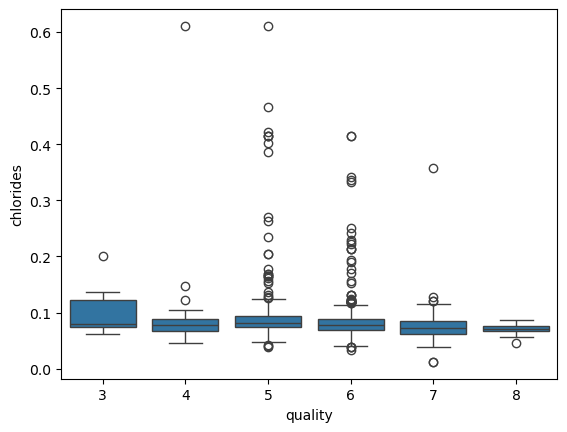

In [14]:

sns.boxplot(x='quality', y='chlorides', data=df)

##### En la relacion de chlorides con quality se puede ver que los outliers estan presentes en todas las categorias y en su mayoria para las categorias 5 y 6. Ademas, se puede ver que las variables numericas en su mayoria se presenta en un rango bajo, pero todas tienen outliers por lo que se mantiene el escalamiento para trabajar los outliers. 

In [22]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['quality'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Definir columnas tipo numerica
dato_numerico = X_train.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()

# Definir transformaciones
transformar_numericos = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())])
# Combinar tranformaciones

preprocesamiento = ColumnTransformer(
    transformers=[
        ('num', transformar_numericos, dato_numerico)
    ])

# Integrar preprocesamiento
pipeline = Pipeline(steps=[('preprocesamiento', preprocesamiento)])

# Preprocesar los datos de entrenamiento y prueba
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [38]:
# Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizar predicciones
y_pred_knn = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred_knn))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print('Matriz de Confusión:')
print(conf_matrix)

Exactitud: 0.5589519650655022
Informe de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.61      0.69      0.64        96
           6       0.54      0.56      0.55        99
           7       0.44      0.27      0.33        26
           8       0.00      0.00      0.00         2

    accuracy                           0.56       229
   macro avg       0.32      0.30      0.31       229
weighted avg       0.54      0.56      0.55       229

Matriz de Confusión:
[[ 0  4  2  0  0]
 [ 2 66 28  0  0]
 [ 1 34 55  9  0]
 [ 0  5 14  7  0]
 [ 0  0  2  0  0]]


c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [42]:
# Entrenar el modelo Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Exactitud: {accuracy:.2f}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print('Matriz de Confusión:')
print(conf_matrix)


Exactitud: 0.70
Informe de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.71      0.80      0.75        96
           6       0.68      0.66      0.67        99
           7       0.72      0.69      0.71        26
           8       0.00      0.00      0.00         2

    accuracy                           0.70       229
   macro avg       0.42      0.43      0.43       229
weighted avg       0.67      0.70      0.68       229

Matriz de Confusión:
[[ 0  3  3  0  0]
 [ 0 77 18  1  0]
 [ 0 28 65  6  0]
 [ 0  0  8 18  0]
 [ 0  0  2  0  0]]


c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [41]:
# Crear el modelo de Regresión Logística con hiperparámetros específicos
model = LogisticRegression(penalty='l2',           # Tipo de regularización L2 (Ridge)
C=1.0,                   # Inverso de la fuerza de regularización
solver='lbfgs',          # Algoritmo para la optimización
max_iter=100,            # Número máximo de iteraciones
tol=1e-4,                # Tolerancia para el criterio de parada
random_state=42)         # Semilla para la reproducibilidad

# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [40]:
# Realizar predicciones en el conjunto de prueba
y_pred_lr = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_lr)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred_lr))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print('Matriz de Confusión:')
print(conf_matrix)


Exactitud: 0.62882096069869
Informe de Clasificación:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.68      0.73      0.70        96
           6       0.62      0.64      0.63        99
           7       0.48      0.42      0.45        26
           8       0.00      0.00      0.00         2

    accuracy                           0.63       229
   macro avg       0.36      0.36      0.36       229
weighted avg       0.61      0.63      0.62       229

Matriz de Confusión:
[[ 0  3  3  0  0]
 [ 1 70 23  2  0]
 [ 0 28 63  8  0]
 [ 0  2 13 11  0]
 [ 0  0  0  2  0]]


c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m